# Solver Bare Bones IQ
**author**: Charles-David Hébert

**date**:   January 30 2019

We will solve the Hubbard Model at half-filling, using the known Hartee approximation for the Green Function.

$$ H = \sum_{ij} t_{ ij} c^\dagger_i c_j + U \sum_i n_{i \uparrow} n_{i \downarrow} $$ 

## Mathematical Description

The project here is to build a dynamical mean field theory solver. Extensive references exists, a good starting point being: [DMFT, A. Georges](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.68.13).

The basic equations of DMFT are the following (we will stick to two dimensions):

### Math description of DMFT

\begin{align}
G_{imp}(z) & = \int \frac{dk}{(2 \pi)^2} G_{L}(z, k) \\
G_{L}(z, k) & = \bigg[z - \epsilon(k) - \Sigma(z) \bigg]^{-1} \\
G_{imp}(z) & = \bigg[z - \Delta(z) - \Sigma(z) \bigg]^{-1} 
\end{align}


### In words description of DMFT
The last three equations are iterated until selfconsistency, let us explain in a bit more detail.

#### The impurity solver

| Input                                 | output                                   |
|---------------------------------------|------------------------------------------|
| Hybridization function := $\Delta(z)$ | Impurity Green function :=  $G_{imp}(z)$ |


The Impurity solver's tasks is to compute the Impurity green function $G_{imp}(z)$, with z being a frequency, here a complex frequency, namely a matsubara frequency : $z := i \omega_n = (2n + 1)\frac{\pi}{\beta} $ .
This can be done in mutiple ways, see the above reference.


#### The selfconsistency scheme

Once the calculation of the impurity green function is done, one must update the hybridization function by using the above equations. Once the new hybridization function has been calculated, we go back to solving the impurity once more. If this is a bit mysterious, don't worry too much, it will get clearer as we progress along.


### Picture description of DMFT

![SC](images/figsc.png) 


First let us calculate the first moment of the hybridization function;
A high frequency expansion of the above equations yields:
    
\begin{align}
\Delta(z) & \lim_{z -> \infty} = \frac{\Delta_1}{z} \\
\Delta_1 & =  \int \frac{dk}{(2 \pi)^2} [\epsilon(k)]^2 - \Big[ \int \frac{dk}{(2 \pi)^2} \epsilon(k) \Big]^2  \\
\end{align}

Calculating this high-frequency is important will introduce many concepts

## Introduction to python and functions

In [1]:
import numpy as np
from scipy.integrate import dblquad

In [2]:
def eps_k(kx: float, ky:float )-> float:
    """Calculate the dispersion relation. We set the hopping to t = -1.0 as
        the energy unit, and use the 2D square lattice"""
    return -2.0*(np.cos(kx) + np.cos(ky))

In [3]:
def get_hyb_fm()-> float:
    # define the limits of the brillouin zone in kx
    kx_limit_low = -np.pi
    kx_limit_high = np.pi
    
    # the limits of the brillouin zone in ky need to be function, here inline functions without name,
    # also called lambdas
    ky_limit_low = lambda kx: -np.pi
    ky_limit_high = lambda kx: np.pi
    
    #dblquad returns a tuple with two elements (result: float, error: float), 
    # Here, we grab the first element, by indexing with "[0]" to get the result.
    int_eps_k = dblquad(eps_k, kx_limit_low, kx_limit_high, ky_limit_low, ky_limit_high)[0]
    
    eps_k_squared = lambda kx, ky: eps_k(kx, ky) * eps_k(kx, ky)
    int_eps_k_squared = dblquad(eps_k_squared, kx_limit_low, kx_limit_high, ky_limit_low, ky_limit_high)[0]
    
    return 1.0/(2.0*np.pi)**2.0*(int_eps_k_squared - int_eps_k)
    

In [4]:
get_hyb_fm()

3.999999999999999

## Introduction to classes

In [5]:
# Let us keep the previous elements and define a model class that will be

class Model:

    def __init__(self, t: float, beta: float, U: float, hyb):
        self.t = t # hopping, usaully set to -1.0
        self.beta = beta # 1/Temperature
        self.U = U # Hubbard interaction
        self.hyb = hyb # hybridization
        
    def eps_k(self, kx: float, ky:float) -> float:
        return -2.0*(np.cos(kx) + np.cos(ky))
    
        

In [6]:
from scipy import linalg

class ImpuritySolver:
    
    def __init__(self, model: Model):
        self.model = model
        
    def solve(self):
        green_impurity = np.zeros(self.model.hyb.shape, dtype=complex)
        
        # We know the result for the Hartee part of the self-energy:
        # Sigma(z) = U/2.0
        
        self_energy = self.model.U / 2.0 *np.ones(green_impurity.shape, dtype=complex)
        
        for n in range(green_impurity.shape[0]):
            iwn = 1.0j * (2.0 * n + 1.0 ) * np.pi / self.model.beta
            
            # we index the numpy array with the "[]" operator. If the array was two dimensional,
            # we could index with two variables.
            green_impurity[n] = 1.0/(iwn - self.model.hyb[n] - self_energy[n])
        
        return green_impurity
        
    

In [7]:
class SelfConsistency:
    
    def __init__(self, model, green_impurity):
        self.model = model
        self.green_impurity = green_impurity
        
        
    def green_lattice_scalar_real(self, kx, ky, self_energy, n):
        """ Return the lattice green function for one frequency, given by the index n"""
        
        iwn = 1.0j * (2.0 * n + 1.0) * np.pi / self.model.beta
        return np.real(1.0/(iwn - self.model.eps_k(kx, ky) - self_energy[n]))
    
    def green_lattice_scalar_imag(self, kx, ky, self_energy, n):
        """ Return the lattice green function for one frequency, given by the index n"""
        
        iwn = 1.0j * (2.0 * n + 1.0) * np.pi / self.model.beta
        return np.imag(1.0/(iwn - self.model.eps_k(kx, ky) - self_energy[n]))
    
    def run_selfconsistency(self):
        
        # 0.) extract the self-energy from the green_impurity
        
        self_energy = np.zeros(self.green_impurity.shape, dtype=complex)
        for n in range(self.green_impurity.shape[0]):
            iwn = 1.0j * (2.0 * n + 1.0 ) * np.pi / self.model.beta
            self_energy[n] = iwn - self.model.hyb[n] - 1.0/self.green_impurity[n]
            
#         print("self_energy = ", self_energy)
        # 1.) Calculate a new green_impurity using the lattice green function
        green_impurity_new = np.zeros(self.green_impurity.shape, dtype=complex)
        
        
        kx_limit_low = -np.pi
        kx_limit_high = np.pi
        ky_limit_low = lambda kx: -np.pi
        ky_limit_high = lambda kx: np.pi
        
        for n in range(green_impurity_new.shape[0]):
            green_impurity_new[n] = dblquad(self.green_lattice_scalar_real, kx_limit_low, kx_limit_high, 
                                            ky_limit_low, ky_limit_high, args=(self_energy, n))[0]
            green_impurity_new[n] += 1.0j*dblquad(self.green_lattice_scalar_imag, kx_limit_low, kx_limit_high, 
                                            ky_limit_low, ky_limit_high, args=(self_energy, n))[0]
            
            green_impurity_new[n] /= (2.0*np.pi)**2.0
            
        
#         # 2.) extract new hyb
        hyb_new = np.zeros(self.green_impurity.shape, dtype=complex)
        for n in range(hyb_new.shape[0]):
            iwn = 1.0j * (2.0 * n + 1.0 ) * np.pi / self.model.beta
            hyb_new[n] = iwn - 1.0/green_impurity_new[n] - self_energy[n]
        
        
        return hyb_new

In [8]:
from tqdm import tqdm

def main():
    
    # 0.) define the simulation parameters
    n_freq: int = 200 # we keep 100 frequencies
    t = -1.0
    beta = 10.0
    U = 4.0
    iter_max = 20 # maximum number of iterations
    
    # initial guess for the hybridization, hmmm. no clue so put it to zero !
    hyb = np.zeros(n_freq, dtype=complex)
    
    for ii in tqdm(range(iter_max)):
        model = Model(t, beta, U, hyb)
        impurity_solver = ImpuritySolver(model)
        green_impurity = impurity_solver.solve()
        selfconsistency = SelfConsistency(model, green_impurity)
        hyb = selfconsistency.run_selfconsistency()
    
    frequencies = np.array([(2.0*n + 1)*np.pi/beta for n in range(n_freq)])
    return (frequencies, hyb)


In [9]:
frequencies, hyb = main()

100%|██████████| 20/20 [00:44<00:00,  2.14s/it]


(-2.0, 0.1)

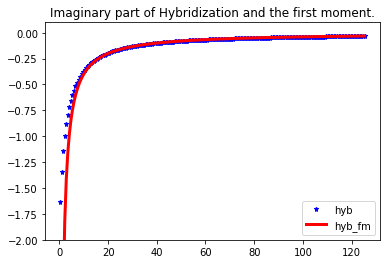

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(frequencies, hyb.imag, 'b*', label="hyb", markersize=5)
plt.plot(frequencies, -4.0/frequencies, 'r-', label="hyb_fm" , linewidth=3)
plt.legend()
plt.title("Imaginary part of Hybridization and the first moment.")
# plt.xlim(80, 120)
plt.ylim(-2.0, 0.1)